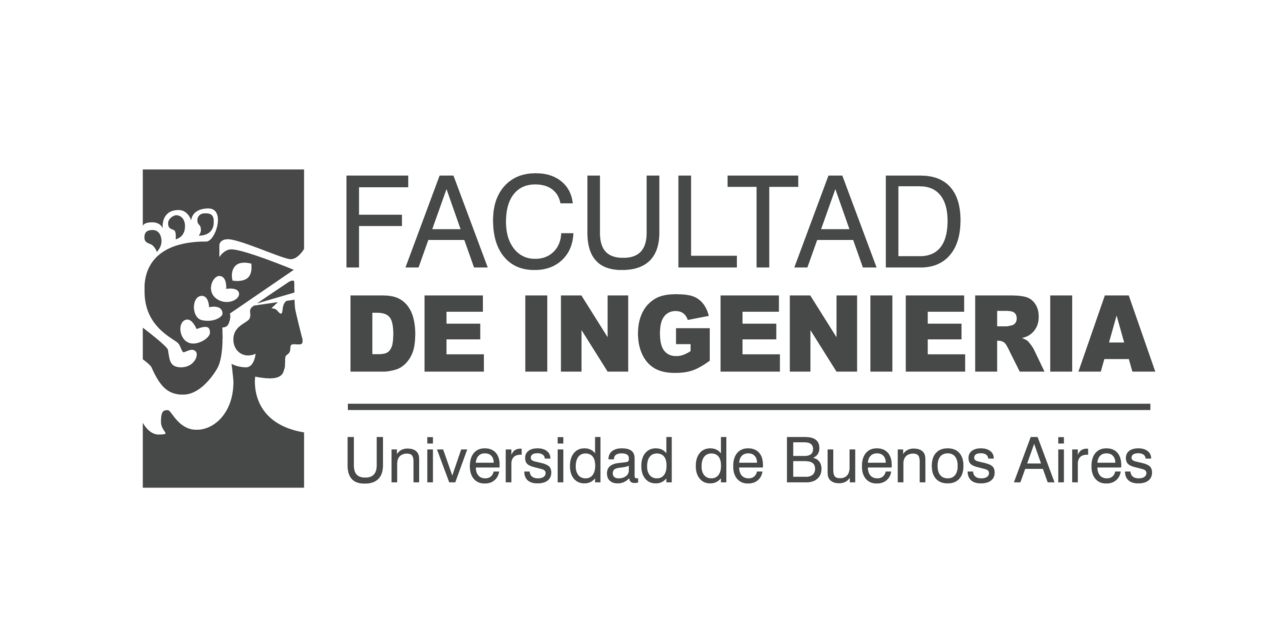

## Aprendizaje Profundo - TP2
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna: **Clasificador de Emociones**

Este segundo TP comienza desde el día después de la clase 5 (2 de abril) y la ventana de entrega estará abierta hasta las **23hs del miércoles 23 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/XatA691so4eVxZB68)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/10EWwOriegjawQ3evl1nuIldY3pUR-hQc/view?usp=sharing

## Prerequisitos y dependencias

In [ ]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

In [130]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# PARAMETROS GLOBALES
BATCH_SIZE = 128
WORKERS = 4
DATASET_AUGMENTED_SIZE = 40000

In [ ]:
# Descarga dataset
!gdown --id 10EWwOriegjawQ3evl1nuIldY3pUR-hQc --output emotions_dataset.zip
!unzip emotions_dataset.zip -d emotions_dataset

## Utils

In [149]:
def dataset_analysis(dataset_path: str, train_counts: dict, test_counts: dict) -> None:
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)
        print(f"Processing {split} split {split_path}...")
        if os.path.exists(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                print(f"Processing emotion {emotion} in {emotion_path}...")
                if os.path.isdir(emotion_path):
                    image_count = len([img for img in os.listdir(emotion_path) if img.endswith(('.jpg'))])
                    if split == "train":
                        train_counts[emotion] += image_count
                    elif split == "test":
                        test_counts[emotion] += image_count
                        
def plot_class_distribution(train_counts, test_counts) -> None:
    labels = train_counts.keys()
    train_values = train_counts.values()
    test_values = test_counts.values()
    total_train_images = sum(train_values)
    total_test_images = sum(test_values)

    x = np.arange(len(labels))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label=f'Train (Total: {total_train_images})')
    rects2 = ax.bar(x + width/2, test_values, width, label=f'Test (Total: {total_test_images})')

    ax.set_xlabel('Clases de emociones')
    ax.set_ylabel('# de imagenes')
    ax.set_title('Distribución de clases en train y test')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()
    
def mean_std_dataset(dataset_path: str) -> tuple:
    # Transformación base: solo ToTensor para que los valores estén entre 0 y 1
    transform = transforms.ToTensor()

    # Cargar el dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    # Calcular media
    print("Calculando media...")
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        total_pixels += batch_samples * images.size(2) * images.size(3)  # H * W por imagen
        mean += images.sum(dim=[0, 2, 3])

    mean /= total_pixels

    # Calcular desviación estándar
    print("Calculando desviación estándar...")
    for images, _ in tqdm(loader):
        std += ((images - mean[None, :, None, None]) ** 2).sum(dim=[0, 2, 3])

    std = torch.sqrt(std / total_pixels)

    print(f"Media por canal: {mean}")
    print(f"Desviación estándar por canal: {std}")
    
    return mean, std

def denormalize(img_tensor, mean, std) -> torch.Tensor:
    """Desnormaliza un tensor de imagen (in-place)"""
    img = img_tensor.clone()
    for z_img, z_mean, z_std in zip(img, mean, std):
        z_img.mul_(z_std).add_(z_mean) # img = img * std + mean
    return img

def show_image(img_tensor, mean=None, std=None) -> None:
    """Muestra una imagen tensorizada con o sin desnormalizar"""
    if mean is not None and std is not None:
        img_tensor = denormalize(img_tensor, mean, std)

    img_np = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    plt.imshow(img_np.clip(0, 1))  # clamp para estar seguros
    plt.axis('off')
    plt.show()

def show_first_images_per_class(
        dataset: torchvision.datasets.ImageFolder, 
        class_names: list,
        mean: float,
        std: float
    ) -> None:
    """
    Mostrar primera imagen de cada clase

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset a visualizar.
        class_names (list): Lista de clases del dataset.
    """
    images_by_class = {}
    
    # Recorrer el dataset y guardar la primera imagen de cada clase en images_by_class
    for img, label in dataset:
        if label not in images_by_class:
            images_by_class[label] = img
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(images_by_class.items()):
        img = denormalize(img, mean, std) 
        img = img.permute(1, 2, 0).numpy() # [3, H, W] → [H, W, 3]
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def map_counts_to_classnames(counter_dict: dict, class_names: list) -> dict:
    return {class_names[k]: v for k, v in sorted(counter_dict.items())}

# igual a show_first_images_per_class pero con DataLoader 
def show_first_images_per_class_from_loader(
    dataloader,
    class_names: list,
    mean: list,
    std: list
) -> None:
    """
    Mostrar la primera imagen de cada clase desde un DataLoader con transformaciones activas.
    """
    images_by_class = {}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in images_by_class:
                images_by_class[label] = img
            if len(images_by_class) == len(class_names):
                break
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(sorted(images_by_class.items())):
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## 1. Preprocesamiento de Datos

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan las técnicas que consideren pertinentes.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.

In [ ]:
# Dataset path
dataset_path = "emotions_dataset/dataset_emociones"

# Inicializamos dicts en int 0
train_counts = defaultdict(int)
test_counts = defaultdict(int)

dataset_analysis(dataset_path, train_counts, test_counts)   

print("Counts por emocion para train:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nCounts por emocion para test:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count}")

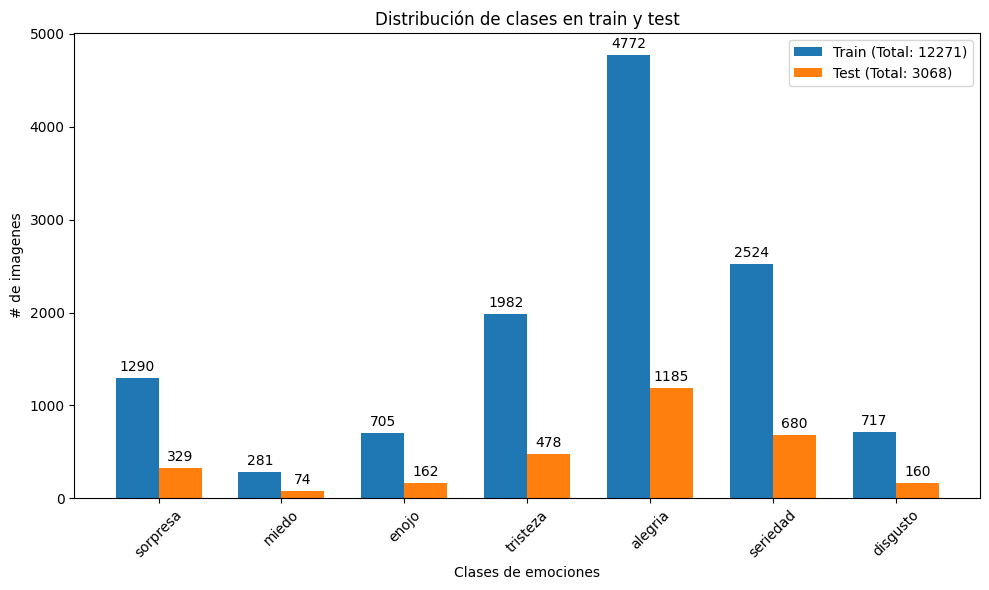

In [122]:
plot_class_distribution(train_counts, test_counts)

Se observa un desbalanceo considerable en las clases para ambos splits (train, test). Se pueden aplicar transformaciones con torch.vision para balancear aplicando rotaciones, cambios de escala, transformaciones en escalas de grises o colores, etc. Vemos que alegría es la mas desbalanceada positivamente en ambos dataset y miedo la que menos frecuencia tiene, se entiende que esto puede explicarse ya que las personas activamente propoician fotos cuando estan alegres y las evitan en el otro extremo.

In [123]:
# Para evitar data leakage obtengo mean y std de train dataset nada mas
train_mean, train_std = mean_std_dataset(dataset_path + "/train")
# mean_std_dataset(dataset_path + "/test")

Calculando media...


100%|██████████| 96/96 [00:01<00:00, 51.24it/s]


Calculando desviación estándar...


100%|██████████| 96/96 [00:02<00:00, 44.51it/s]

Media por canal: tensor([0.5752, 0.4495, 0.4012])
Desviación estándar por canal: tensor([0.2652, 0.2422, 0.2407])


In [124]:
transform = transforms.Compose([
    transforms.Resize((100, 100)), # se valida por inspección que 100x100 es el tamaño actual del dataset
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)

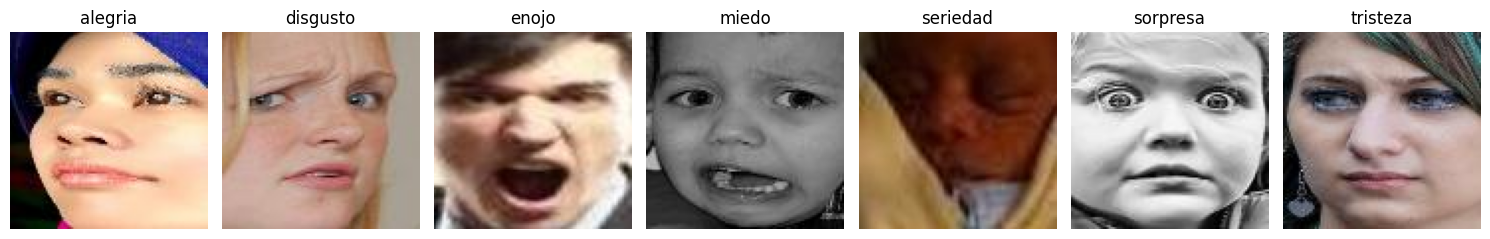

In [125]:
show_first_images_per_class(train_dataset, train_dataset.classes, train_mean, train_std)

Como se dijo anteriormente. ~12k imagenes para 7 clases y con el desbalance observado parece poco para entrenar una red neuronal para esta tarea. Se realizara data augmentation con transformaciones. De esta manera atacaremos 3 frentes:
- Disminuir desbalance de clases
- Aumentar la cantidad de datos para mejorar la performance de la red neuronal en la tarea de clasificación
- Hacer al modelo a entrenar mas robustos a las transfromaciones aplicadas (por ejemplo, podra reconocer mejor emociones de caras rotadas si hacemos augmentation con transformaciones de rotación)

In [135]:

train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(100, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=train_transform)

# Calcular pesos de clase para el muestreo
targets = train_dataset.targets
class_counts = Counter(targets)
num_samples = len(train_dataset)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}

sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.DoubleTensor(sample_weights) # convertir a tensor

print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de dataset original: {len(sample_weights)}")
print(f"Tamaño dataset con augmentation: {DATASET_AUGMENTED_SIZE}")

# Usar WeightedRandomSampler para balancear el dataset
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=sampler,
                          num_workers=WORKERS)

Pesos por clase: {0: 2.571458507963118, 1: 17.11436541143654, 2: 17.405673758865248, 3: 43.669039145907476, 4: 4.8617274167987325, 5: 9.512403100775193, 6: 6.191220988900101}
Tamaño de dataset original: 12271
Tamaño dataset con augmentation: 40000


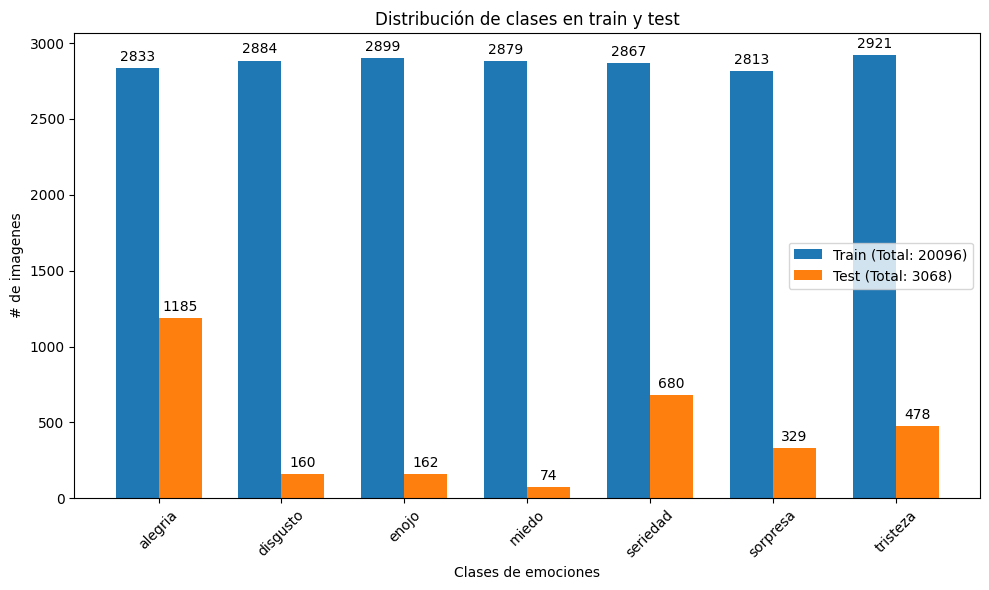

In [133]:
# Probamos el DataLoader y WeightedRandomSampler para ver balanceo de clases
sampled_labels = []
for i, (_, labels) in enumerate(train_loader):
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= 20000:  # tomamos una muestra
        break

# Contamos cuántas veces aparece cada clase
balanced_train_counts = Counter(sampled_labels)

train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(Counter(test_dataset.targets), test_dataset.classes)

plot_class_distribution(train_counts_named, test_counts_named)

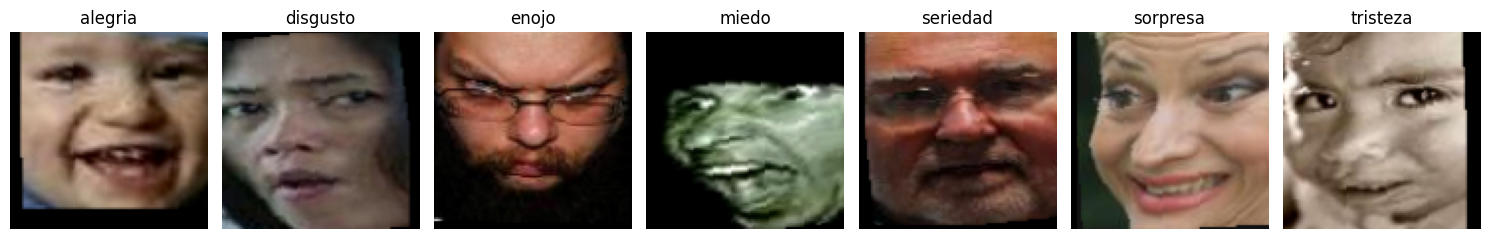

In [148]:
show_first_images_per_class_from_loader(train_loader, train_dataset.classes, train_mean, train_std)

## 2. Construcción y entrenamiento del Modelo CNN

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes.

## 3. Evaluación del Modelo

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.

 ## 4. Prueba con Imágenes Nuevas

Subir al menos 3 imágenes personales (con el rostro de ustedes o de otras personas), que no formen parte del dataset de entrenamiento ni de testeo.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo preprocesamiento que se usó para el dataset.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original (preprocesada)

  - La clase inferida por el modelo

- Redactar conclusiones y comentarios finales